In [2]:
# Import required modules
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt


# Explore the data
team_flights = pd.read_csv('../Datasets/team_flights.csv')
fuel_prices = pd.read_csv('../Datasets/fuel_prices_2101.csv',
                         index_col='date')

team_flights.head()

# Some basic data cleaning and pre-processing
team_flights['departure_datetime'] = pd.to_datetime(team_flights['departure_datetime'])
team_flights['landing_datetime']   = pd.to_datetime(team_flights['landing_datetime'])

fuel_prices.index = pd.DatetimeIndex(fuel_prices.index).to_period('D')

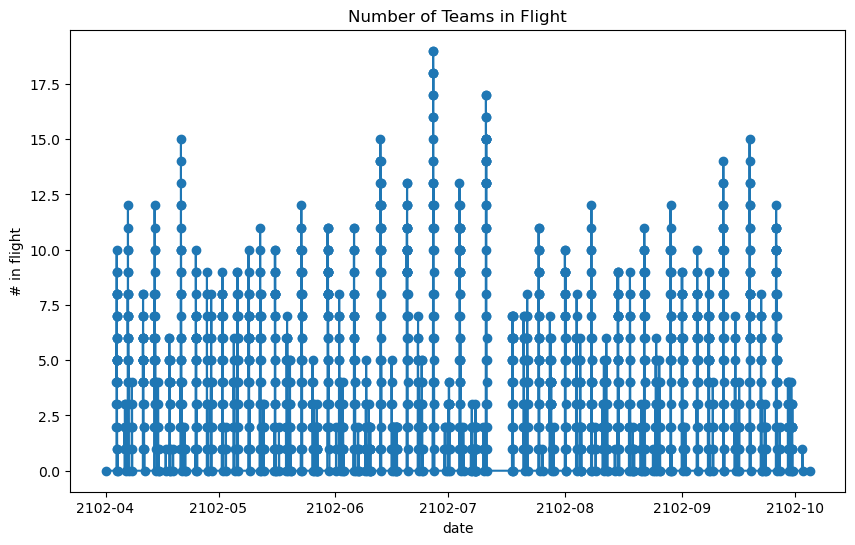

Total fuel cost:  1859925.3636966238


In [3]:
# 1. max_teams_in_flight
# First we'll want to know the minimum time between any two unique flight event times in the season
# To do this we first create a single array of times
all_datetimes = pd.concat([team_flights['departure_datetime'], team_flights['landing_datetime']])

# Sort the array of datetimes
all_datetimes_sorted = sorted(list(set(all_datetimes)))
all_datetimes_sorted.append(pd.to_datetime('2102-04-01 00:00:00')) #optional
all_datetimes_sorted.append(pd.to_datetime('2102-10-05 00:00:00')) #optional

# convert to data frame
in_flight_df = pd.DataFrame({'date':sorted(all_datetimes_sorted),
                             'in_flight':0})
# iterate through each known flight, and increment corresponding rows of in_flight_df
for index, flight in team_flights.iterrows():
    in_flight_df.loc[(in_flight_df['date']>=flight['departure_datetime']) &
                     (in_flight_df['date']<flight['landing_datetime']),'in_flight'] += 1

# Plot 
fig, ax = plt.subplots(figsize=(10, 6)) #optional size parameter
ax.step(in_flight_df['date'], in_flight_df['in_flight'], where='post') # optional
ax.scatter(in_flight_df['date'], in_flight_df['in_flight'])
ax.set_xlabel('date') # optional
ax.set_ylabel('# in flight') # optional
ax.set_title('Number of Teams in Flight') # optional
plt.show()

max_teams_in_flight = 19  # based on graph



# 2. total_fuel_spend_2102_dollars

# First we'll need to project fuel prices into 2102
# then we'll apply them to our flight info
# Fit Seasonal ARIMA model
model = SARIMAX(fuel_prices,
              order=(1, 1, 1),             # for linear growth term
              seasonal_order=(1, 0, 0, 7)  # for 7 day periodicity
              )
model_fit = model.fit()

# Forecast fuel prices for 2102
forecast = model_fit.get_forecast(steps=365)  # Forecast prices for 365 days in 2102

# Convert to Data Frame
fuel_prices_forecast = pd.DataFrame(data={"date": forecast.summary_frame().index.to_timestamp(), 
                                          "price":forecast.predicted_mean.values})

# Now we can apply to the flight data
# Step 1: Extract the date portion from the adjusted departure datetime
team_flights['departure_date'] = team_flights['departure_datetime'].dt.date

# Step 2: Join fuel_prices DataFrame based on the date
fuel_prices_forecast['date'] = fuel_prices_forecast['date'].dt.date
fuel_prices_forecast.set_index('date', inplace=True)
merged_df = team_flights.join(fuel_prices_forecast, on='departure_date', how='left')

# Step 3: Calculate the fuel cost for flights
# multiply price per mile
merged_df['fuel_cost_total'] = merged_df['price'] * merged_df['travel_distance_miles']

# Step 4: Calculate the overall fuel cost
total_fuel_spend_2102_dollars = merged_df['fuel_cost_total'].sum()
print("Total fuel cost: ",total_fuel_spend_2102_dollars)